In [88]:
import anndata
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import *
from PixelGen.scvi_utils import plot_validation_loss
from PixelGen.tests import test_convert_edgelist_to_protein_pair_colocalization

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator.statistics import clr_transformation
from pixelator.analysis.normalization import dsb_normalize


import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson
from torch.distributions import kl_divergence as kl

from PixelGen.modules import NormalVAE, NormalSCVI
from cytovi import CytoVI

print(torch.cuda.is_available())

%load_ext autoreload
%autoreload 2

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run with scvi-tools version: 1.2.2.post2


In [89]:
DATA_DIR = Path('./PixelGen/datasets')


FILENAMES = [
    "Sample03_Raji_control.layout.dataset.pxl",
    "Sample04_Raji_Rituximab_treated.layout.dataset.pxl",
]

SAMPLE_NAMES = [
    "control", 
    "treated",
]

# COMBINED_FILENAME = "combined_resting_data.pxl"

COMBINED_FILENAME = "cd20_combined.pxl"
COMBINED_PROCESSED_NAME = "cd20_combined_PROCESSED.pxl"

combined_path = DATA_DIR / COMBINED_FILENAME

# pg_data = pixelator.read(DATA_DIR / COMBINED_PROCESSED_NAME)
# adata = pg_data.adata

if os.path.exists(combined_path):
    pg_data = pixelator.read(combined_path)
else:
    
    baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/cd20-rituximab-v1.0-immunology-I"
    for filename in FILENAMES:
        !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} {baseurl}/{filename}

    datasets = [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
    pg_data = pixelator.simple_aggregate(
        SAMPLE_NAMES, datasets
    )
    pg_data.save(combined_path, force_overwrite=True)

In [90]:
adata = pg_data.adata.copy()
adata.raw = adata.copy()
orig_adata = adata.copy()
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='proteins')

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


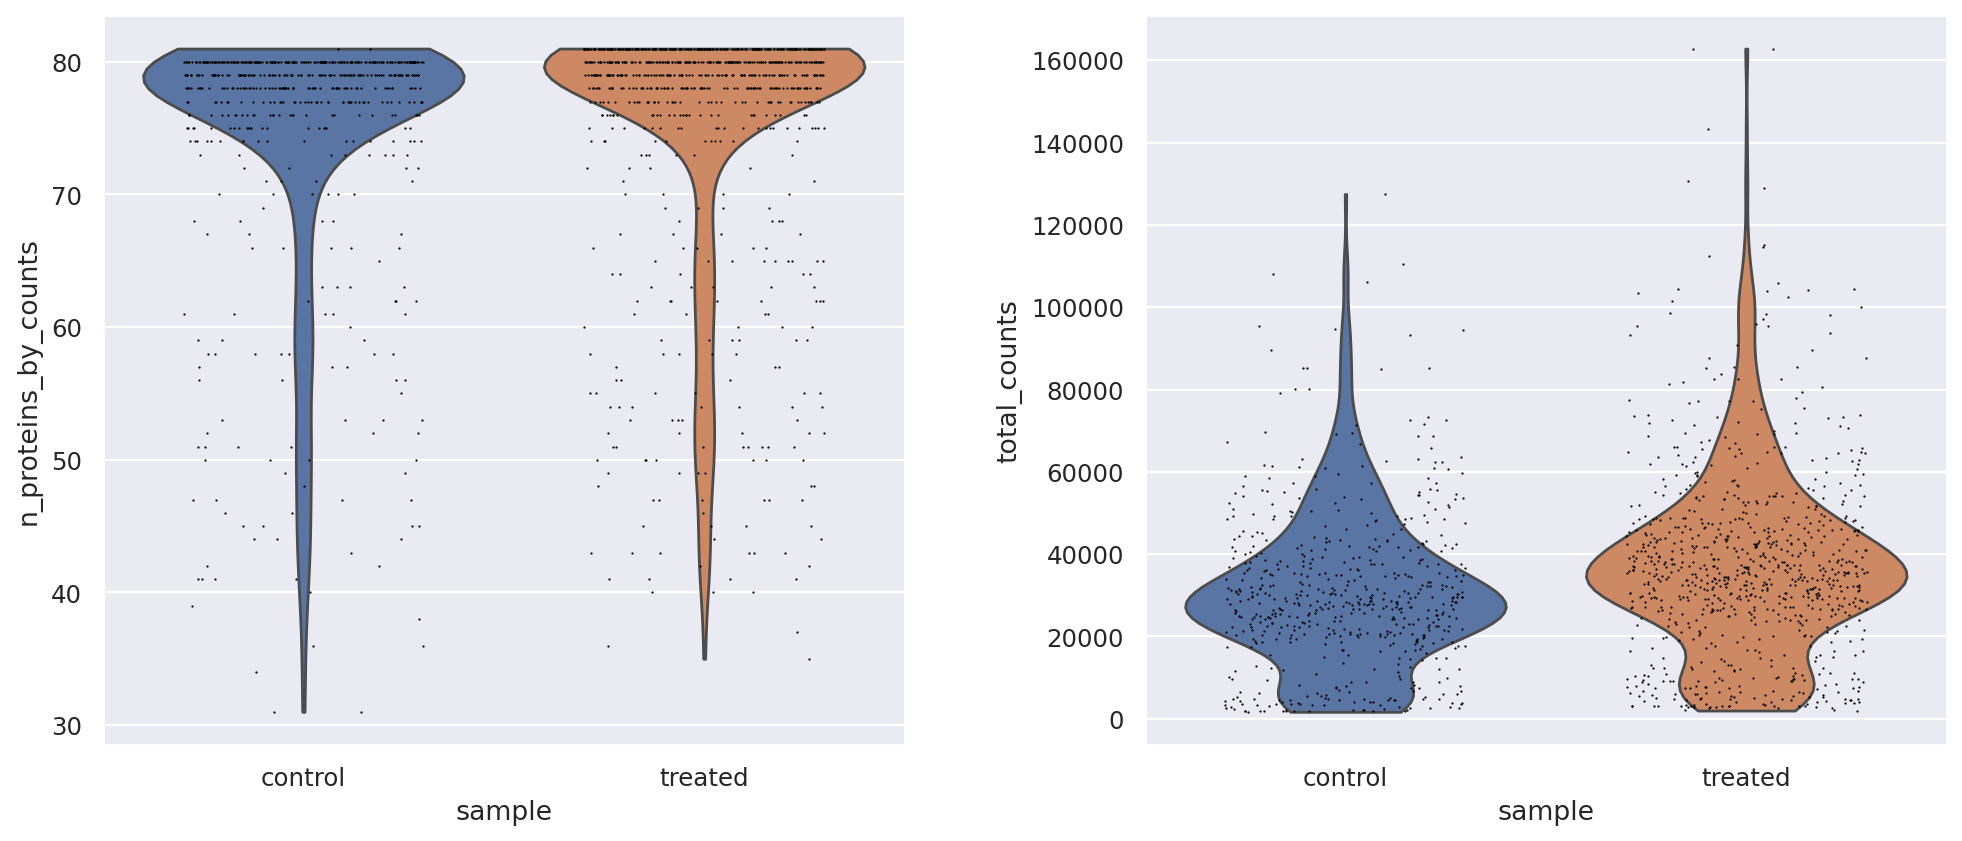

In [91]:
sc.pl.violin(
    adata,
    ["n_proteins_by_counts", "total_counts",],
    groupby='sample',
    jitter=0.3,
    multi_panel=True,
)

/tmp/ipykernel_2106965/1817677247.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/pixelator/plot/__init__.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


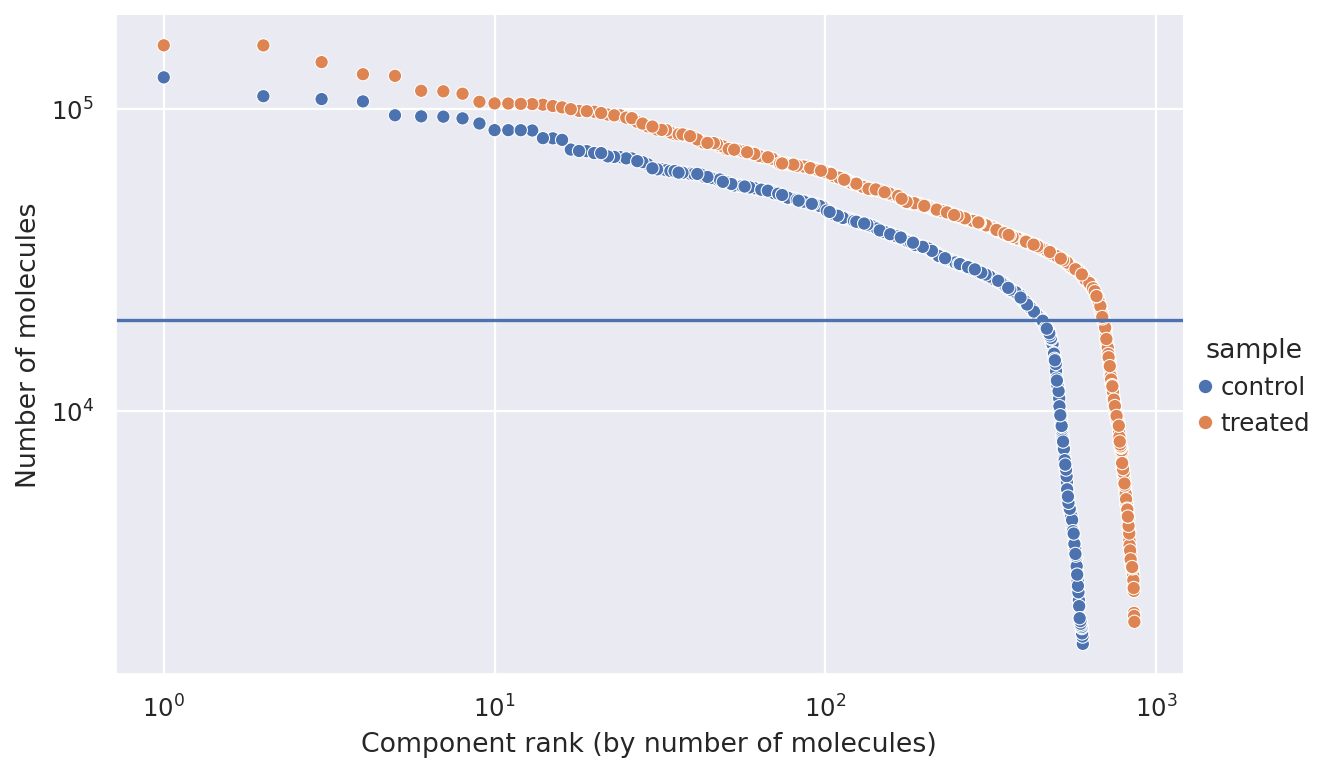

In [92]:
molecule_rank_df = adata.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig_intersection, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")
ax.axhline(y=20000)

/tmp/ipykernel_2106965/61645433.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/pixelator/plot/__init__.py:271: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(color_by).size().reset_index(name="n")


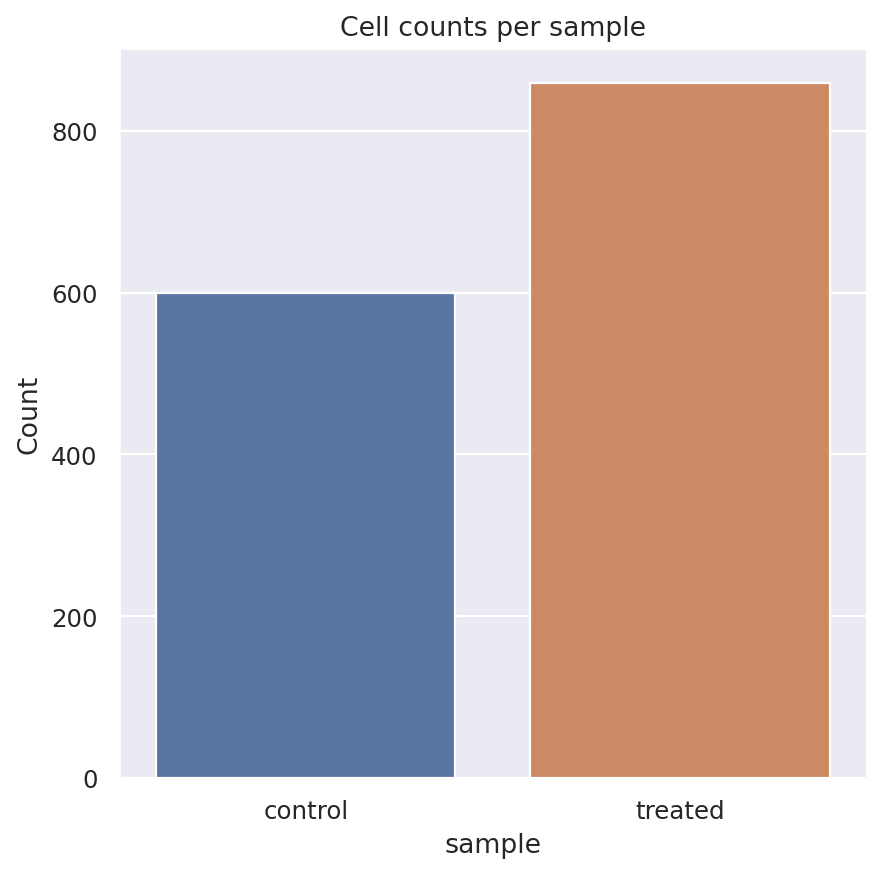

In [93]:
cells_per_sample_df = (
    adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
)

fig, ax = cell_count_plot(adata.obs, color_by="sample")

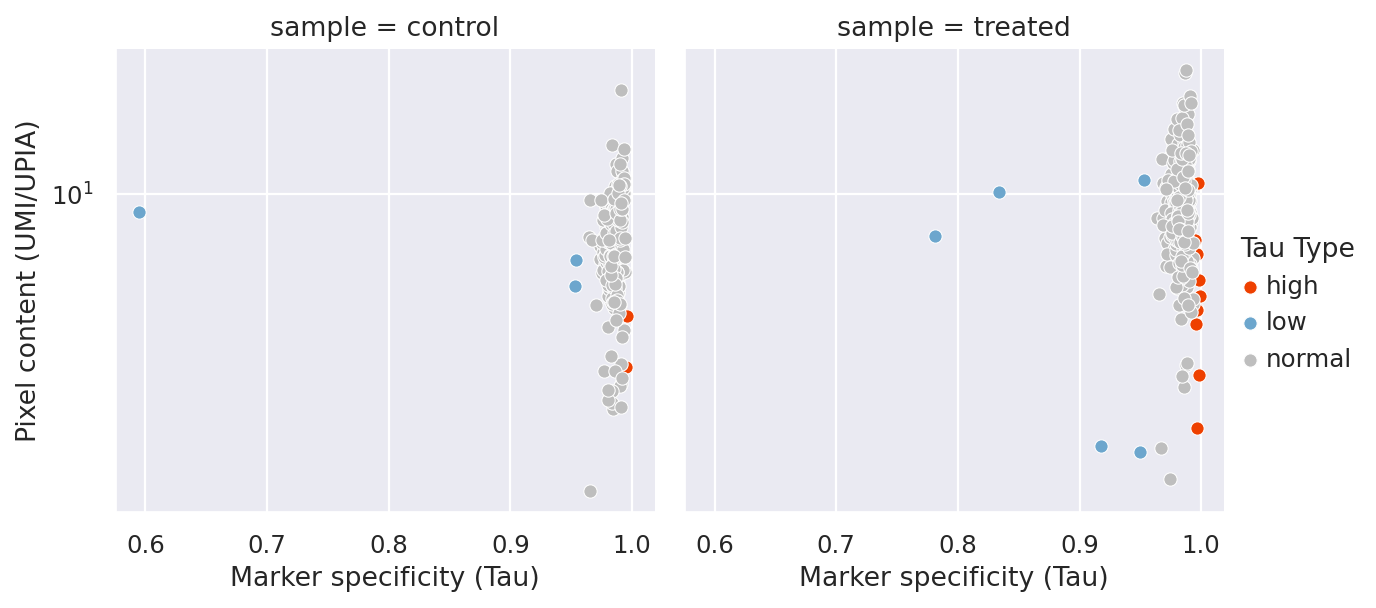

In [94]:
tau_metrics_df = adata.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

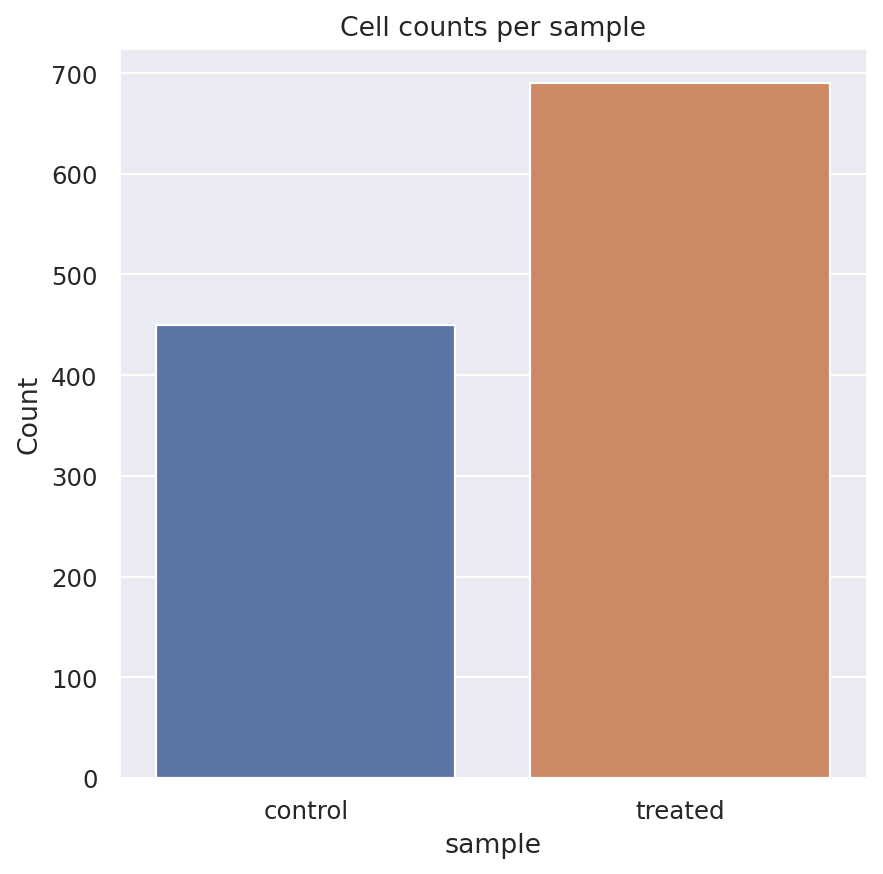

In [95]:
components = adata.obs[
    (adata.obs['tau_type'] == 'normal') & 
    (adata.obs['molecules'] > 20000)
].index
vars = [v for v in adata.var_names]
adata = orig_adata[components, vars]
cells_per_sample_df = (
    adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
)

fig, ax = cell_count_plot(adata.obs, color_by="sample")

<Axes: ylabel='Count'>

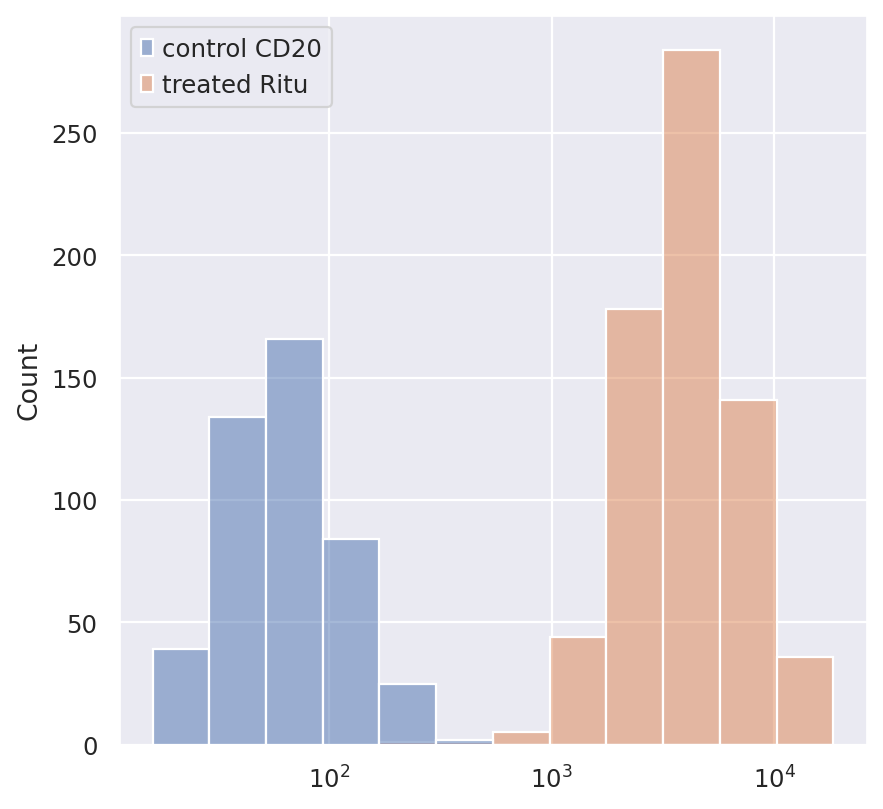

In [97]:
treated_components = [c for c in adata.obs.index if 'treated' in c]
control_components = [c for c in adata.obs.index if 'control' in c]
sns.histplot({'control CD20': adata.to_df().loc[control_components, 'CD20'], 'treated Ritu': adata.to_df().loc[treated_components, 'Rituximab']}, log_scale=True)

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[]

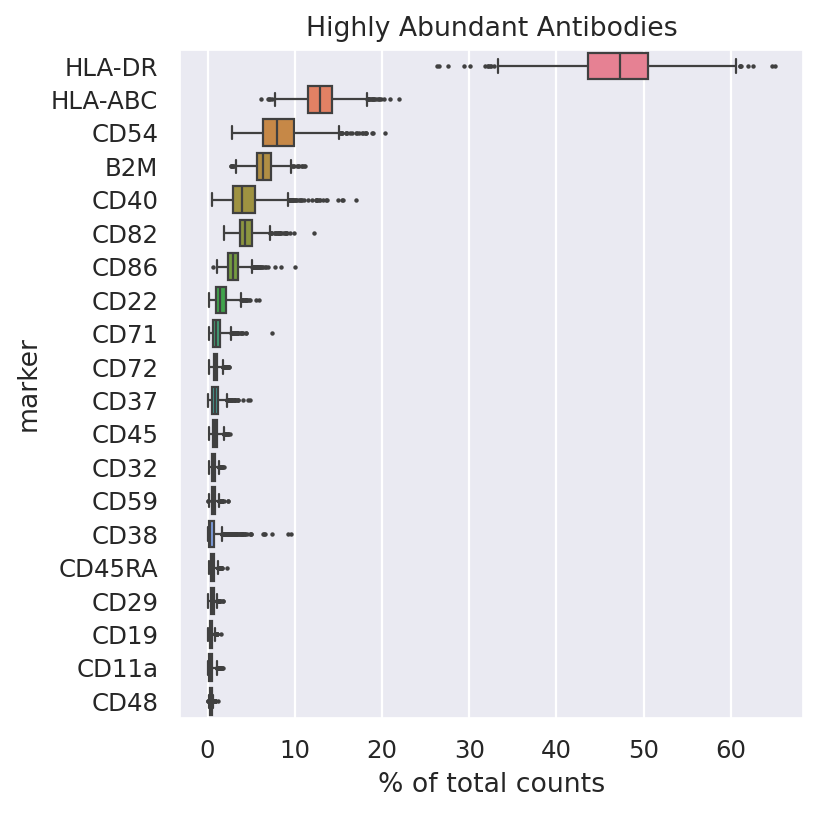

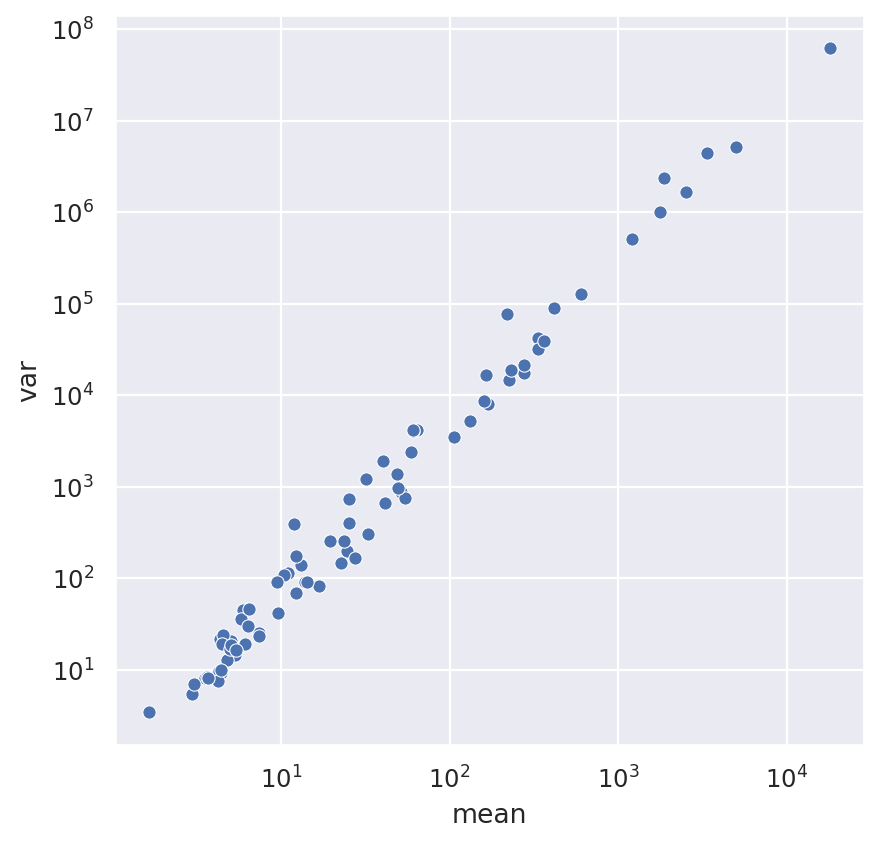

In [9]:
ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
ax.set_title('Highly Abundant Antibodies')
stats = adata.to_df().agg(['mean', 'var',], axis=0).T
fig, ax = plt.subplots(1)
sns.scatterplot(x=stats['mean'], y=stats['var'], ax=ax)
ax.loglog()
# var_genes = sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=20, batch_key='sample', layer='counts', inplace=False)
# sc.pl.highly_variable_genes(var_genes, show=True, log=True)

In [14]:
adata.layers['counts'] = adata.X.copy()
adata.layers['dsb'] = dsb_normalize(adata.to_df('counts'), isotype_controls=['mIgG1', 'mIgG2a', 'mIgG2b'])
adata.layers['clr_by_cell'] = clr_transformation(adata.to_df('counts'), axis=1)
adata.layers['clr_by_ab'] = clr_transformation(adata.to_df('counts'), axis=0)
adata.layers['log1p'] = np.log1p(adata.to_df('counts'))

<Axes: title={'center': 'Cumulative Variance Explained'}>

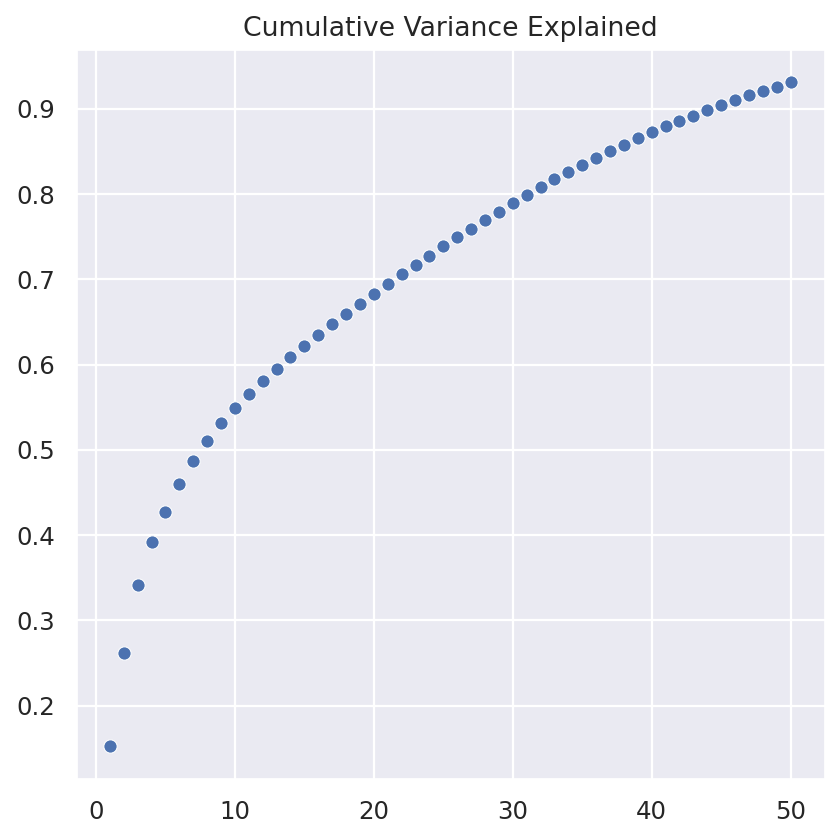

In [15]:
sc.tl.pca(adata, layer='dsb')
plot_cumulative_variance(adata)

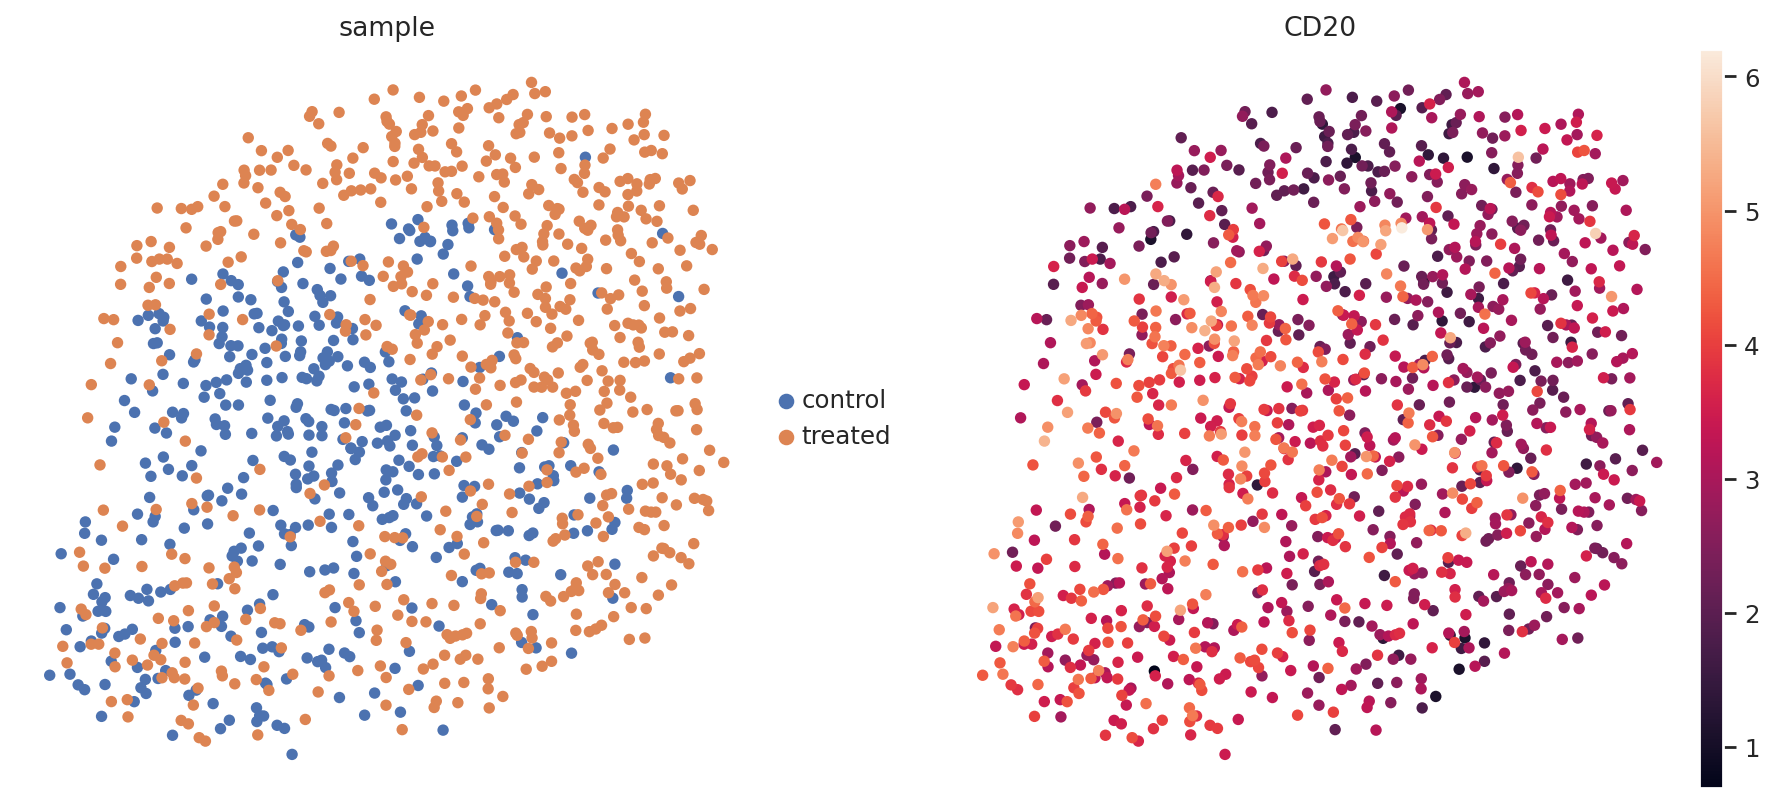

In [16]:
sc.pp.neighbors(adata,)
sc.tl.umap(adata, )
sc.pl.umap(adata, layer='log1p', color=['sample', 'CD20'])

In [24]:
sc.tl.rank_genes_groups(adata, groupby='sample', layer='dsb', use_raw=False, method='wilcoxon')
abundance_de = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=0.05, log2fc_min=1)
abundance_de.sort_values(by='logfoldchanges', ascending=False)

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,control,CD20,27.654522,4.358156,2.462323e-168,1.969858e-166
7,treated,CD45RA,13.435252,3.208849,3.757883e-41,1.002102e-39
8,treated,CD45,12.223887,2.324307,2.317334e-34,3.707735e-33
9,treated,CD84,10.189302,2.214257,2.213464e-24,1.967524e-23
1,control,CD71,15.109666,2.104652,1.398467e-51,5.593867e-50
10,treated,HLA-DR,8.410169,1.725567,4.094227e-17,2.977620e-16
3,control,CD22,12.050336,1.715634,1.931621e-33,2.575495e-32
12,treated,CD29,7.957425,1.629432,1.756566e-15,1.080964e-14
11,treated,CD86,8.096008,1.490647,5.679181e-16,3.786121e-15
17,treated,CD19,6.428772,1.427745,1.286390e-10,5.145559e-10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 50 records. Best score: 40.191. Signaling Trainer to stop.


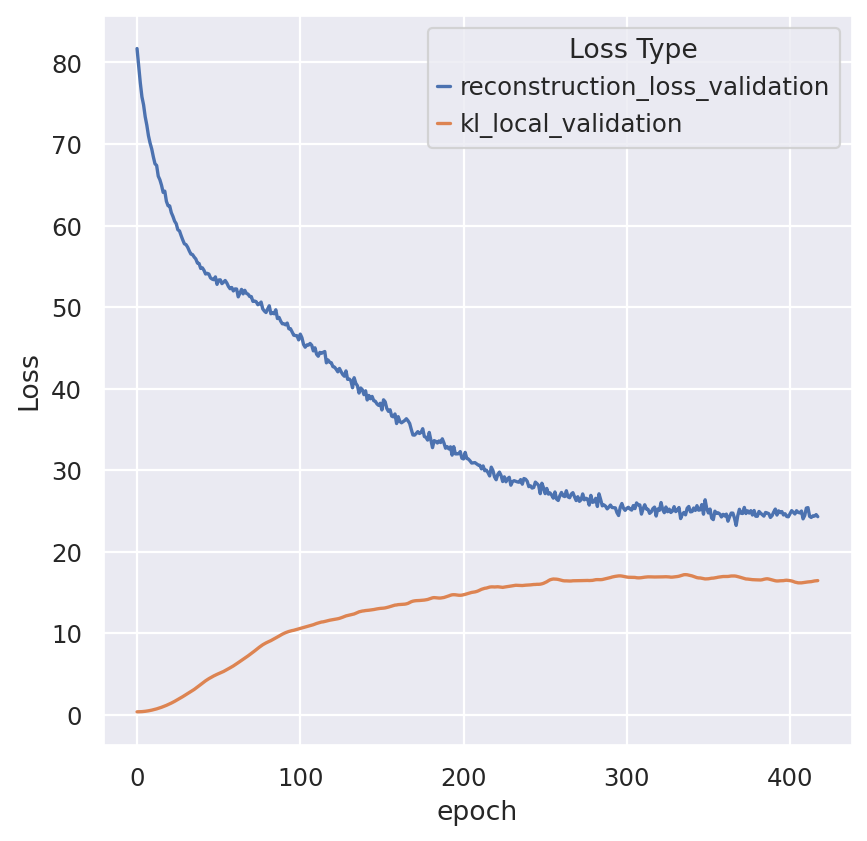

In [18]:
EPOCHS = 10000
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=50, batch_size=2000,
                    max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=400))
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=1, dropout_rate=0.1, prior_mixture=False)
model_cls = CytoVI
model_cls.setup_anndata(adata, layer='dsb', batch_key='sample',)
model = model_cls(adata, **model_kwargs)
model.train(**train_kwargs)
ax = plot_validation_loss(model, semilogy=False)

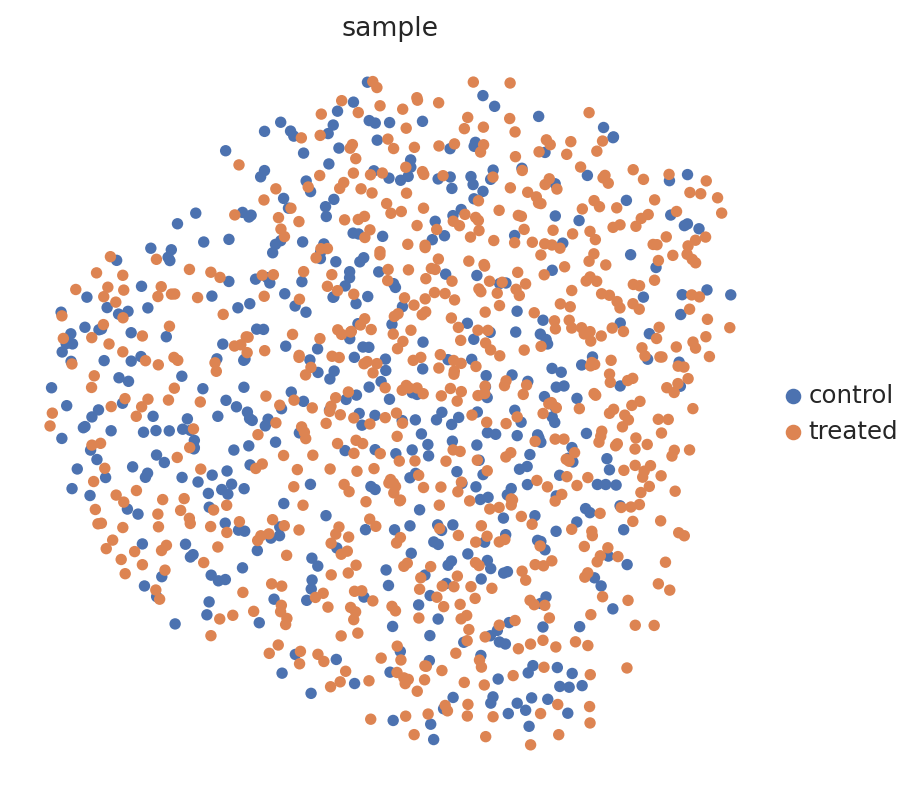

In [19]:
adata.obsm['model_latent'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='model_latent', key_added='model_latent')
sc.tl.umap(adata, neighbors_key='model_latent')
sc.pl.umap(adata, layer='dsb', color=['sample'])

In [25]:
adata.layers['model_decoded'] = model.get_normalized_expression()
sc.tl.rank_genes_groups(adata, groupby='sample', layer='model_decoded', use_raw=False, method='wilcoxon')
decoded_abundance_de = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=0.05, log2fc_min=1)
decoded_abundance_de

,group,names,scores,logfoldchanges,pvals,pvals_adj


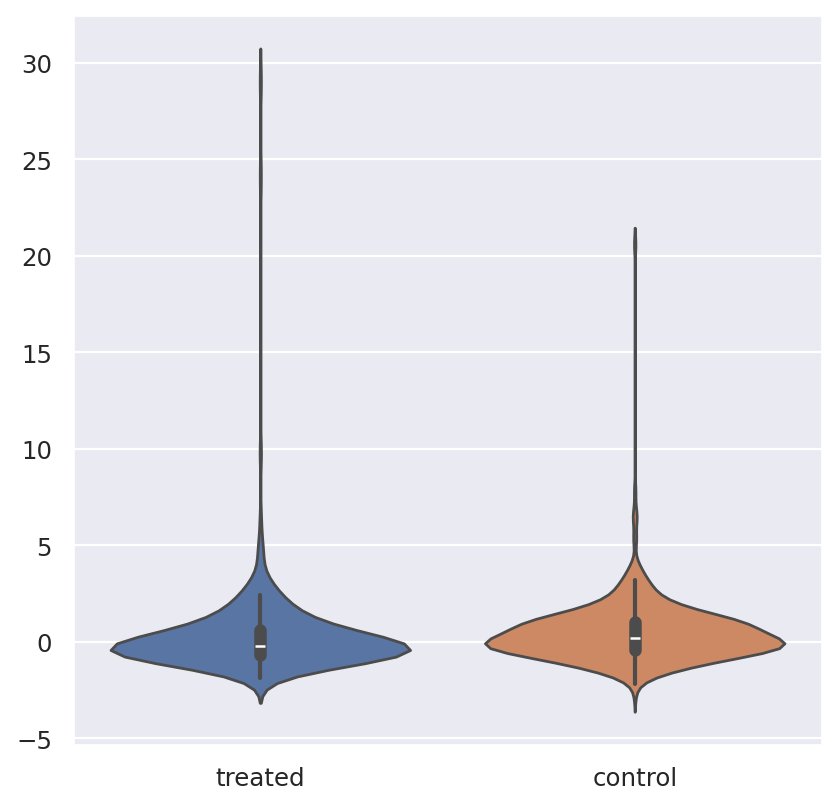

In [42]:
control_pol = pg_data.polarization[pg_data.polarization['sample'] == 'control']
treated_pol = pg_data.polarization[pg_data.polarization['sample'] == 'treated']
ax = sns.violinplot({'treated': treated_pol[treated_pol['marker'] == 'CD20']['morans_z'], 'control': control_pol[control_pol['marker'] == 'CD20']['morans_z']})


In [33]:
polarization = convert_polarization_to_feature_matrix(pg_data.polarization, components=adata.obs.index, key='morans_z', fill_na_with_mean=True)
# polarization = center_feature_matrix(polarization)
# polarization = np.log1p(polarization)
polarization.head(5)

,ACTB_pol,B2M_pol,CD102_pol,CD11a_pol,CD11b_pol,CD11c_pol,CD127_pol,CD137_pol,CD14_pol,CD150_pol,...,CD84_pol,CD86_pol,CD9_pol,HLA-ABC_pol,HLA-DR_pol,Rituximab_pol,TCRVb5_pol,mIgG1_pol,mIgG2a_pol,mIgG2b_pol
component,,,,,,,,,,,,,,,,,,,,,
RCVCMP0000000_treated,-0.723318,1.364380,0.106141,2.592735,0.287299,-0.307552,-0.229781,-0.317992,0.380556,-0.897200,...,3.089267,-0.015386,-0.458820,3.787975,-2.361723,16.170077,0.123326,0.138594,2.114201,0.224971
RCVCMP0000001_control,-0.451024,1.201509,1.259580,1.761256,-0.288351,-0.542682,1.279339,0.230023,-0.345139,0.089343,...,0.219712,-0.047881,-0.324693,2.391027,2.017028,33.740262,-0.135799,-0.240858,-0.073689,-0.117321
RCVCMP0000002_control,-0.610046,0.169949,2.213552,-0.525693,0.287299,0.036660,0.903472,0.230023,0.380556,-0.463951,...,-0.449948,1.021668,-1.111920,-0.249808,0.621811,33.740262,-0.568075,0.138594,-1.073876,0.224971
RCVCMP0000002_treated,-0.446889,-0.115703,0.393270,-0.714957,0.287299,-0.769966,-0.866357,0.230023,0.380556,-0.636780,...,-0.038051,-1.804562,0.269879,0.671582,-5.522206,58.012247,-0.048647,-0.239386,-0.465214,0.224971
RCVCMP0000003_control,0.352720,-0.721888,0.915489,-0.508639,0.287299,0.036660,3.685544,0.230023,0.332188,14.783454,...,2.104633,0.410235,-0.537668,-1.127177,-2.419325,33.740262,2.511289,0.138594,0.445163,-0.333226


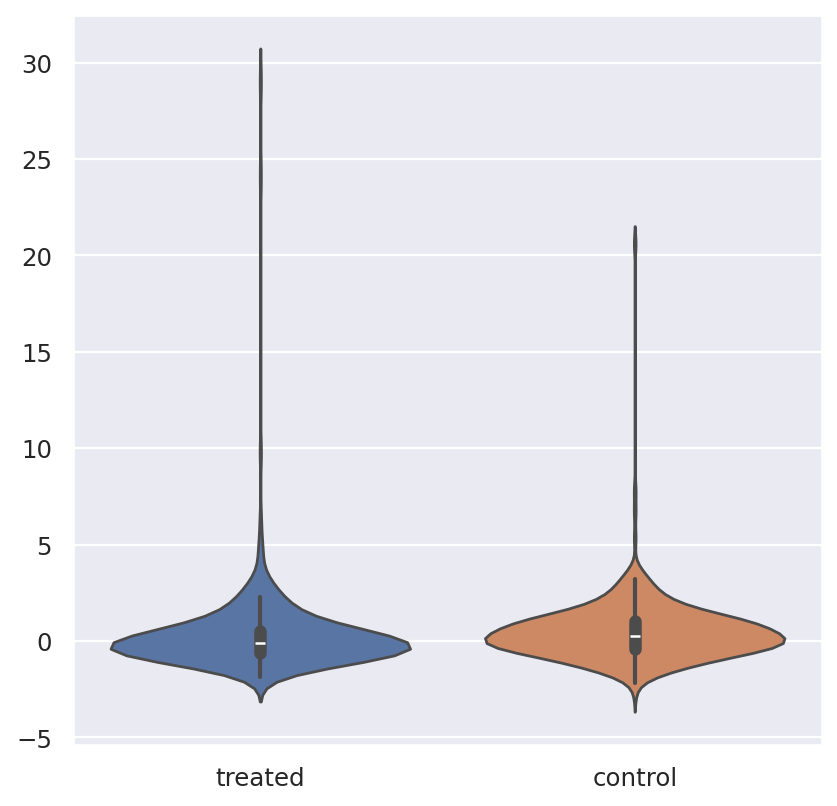

In [37]:
treated_comps = [c for c in polarization.index if 'treated' in c]
treated_pol = polarization[polarization.index.isin(treated_comps)]
control_pol = polarization[~polarization.index.isin(treated_comps)]
ax = sns.violinplot({'treated': treated_pol['CD20_pol'], 'control': control_pol['CD20_pol']})
# ax.set_ylim(-0.03, 0.03)
# sns.boxplot(control_pol['CD20_pol'], ax=ax, label='control')

In [269]:
joint_df = pd.concat((adata.to_df('dsb'), polarization), axis=1)
# joint_df = center_feature_matrix(joint_df) 
all_joint_adata = anndata.AnnData(
    X=joint_df,
    obs=adata.obs
)
components = adata.obs[adata.obs['sample'].isin(['control', 'treated'])].index
joint_adata = all_joint_adata[components, :].copy()
joint_adata.to_df()

,B2M,CD102,CD11a,CD11b,CD11c,CD127,CD137,CD14,CD150,CD152,...,CD84_pol,CD86_pol,CD9_pol,HLA-ABC_pol,HLA-DR_pol,Rituximab_pol,TCRVb5_pol,mIgG1_pol,mIgG2a_pol,mIgG2b_pol
component,,,,,,,,,,,,,,,,,,,,,
RCVCMP0000001_control,-0.111237,0.020757,0.590554,0.689846,0.976934,0.650733,0.433656,0.627862,1.039011,0.550274,...,0.173150,0.126289,-2.816220e-01,0.936001,0.916609,-3.496398e-16,-0.479680,-4.590472e-01,-0.337746,-3.767192e-01
RCVCMP0000002_control,0.093943,0.500458,1.268762,-0.199562,0.321596,0.773023,0.147258,0.733607,0.172127,1.079052,...,-0.598923,0.791504,-7.335876e-01,0.221043,0.716524,-3.496398e-16,-0.583277,-3.614267e-18,-1.014796,1.326919e-17
RCVCMP0000003_control,0.388971,0.752386,-1.940845,-0.062448,0.958235,-0.087922,-0.804261,1.510196,-0.124355,-0.555673,...,2.152715,0.223956,-3.454348e-01,-0.561155,-0.184291,-3.496398e-16,1.655916,-3.614267e-18,0.250258,-5.001553e-01
RCVCMP0000004_control,0.166520,0.160223,0.464360,0.666500,1.397868,0.878061,1.326983,0.454237,0.806964,0.935178,...,-0.099863,4.220202,5.456251e+00,0.011674,-0.439642,-3.496398e-16,-0.311291,-4.469719e-01,-0.402662,2.303378e-01
RCVCMP0000005_control,0.151118,-0.398879,0.697382,-0.147255,1.201521,0.524870,0.867014,0.429644,0.900988,0.793849,...,-0.225879,-0.256588,7.098121e-01,-0.599653,-0.020181,-3.496398e-16,0.096258,-3.614267e-18,-0.231550,1.354103e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCVCMP0001270_treated,0.288102,0.125846,0.916794,-0.671674,0.524413,1.026907,-0.021086,0.814821,0.160985,0.975725,...,-0.470577,0.682532,-7.273977e-18,1.040187,1.175659,1.800521e+00,-0.421984,-3.614267e-18,1.061501,1.326919e-17
RCVCMP0001290_treated,-0.343100,0.269721,-0.622463,-0.490401,1.894717,-0.549201,-0.519769,0.371281,-0.402938,0.308325,...,-0.014713,-0.713908,-7.273977e-18,-0.377166,-0.624159,2.280566e-01,-0.125044,-3.614267e-18,-0.150921,1.326919e-17
RCVCMP0001308_treated,0.196324,-0.388925,1.223397,-0.809393,0.398046,0.558188,0.747464,0.337506,-0.208454,0.267599,...,0.573217,-0.108613,-7.273977e-18,1.309319,-0.149703,-7.717912e-01,-1.685111,-3.614267e-18,0.957080,1.326919e-17


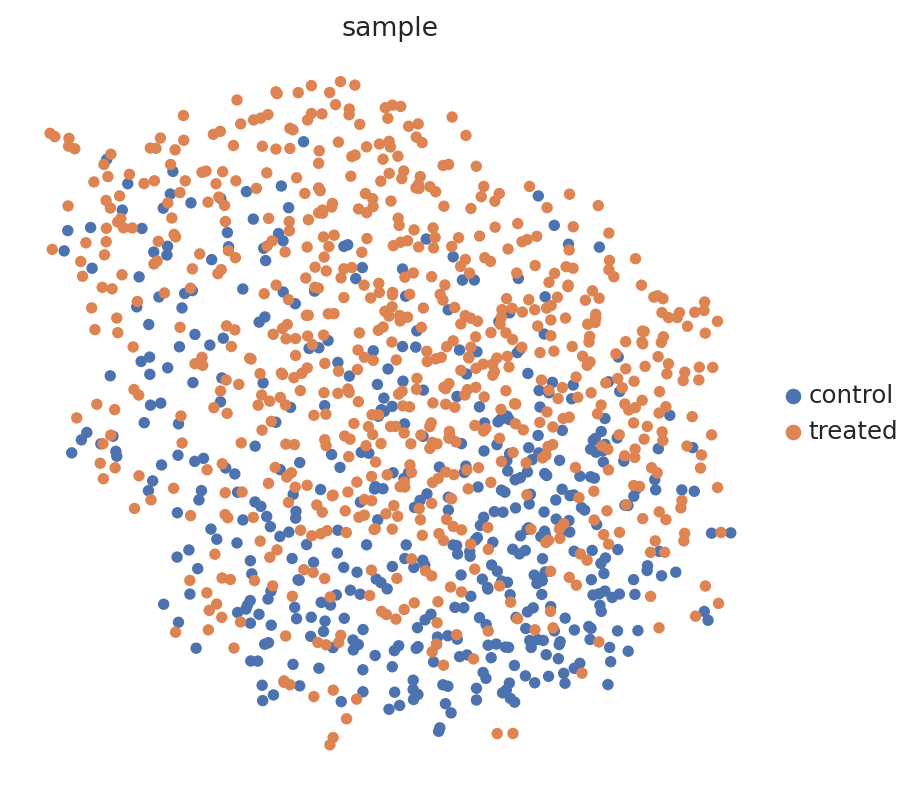

In [270]:
sc.pp.pca(joint_adata)
sc.pp.neighbors(joint_adata)
sc.tl.umap(joint_adata)
sc.pl.umap(joint_adata, color=['sample'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 50 records. Best score: 146.651. Signaling Trainer to stop.


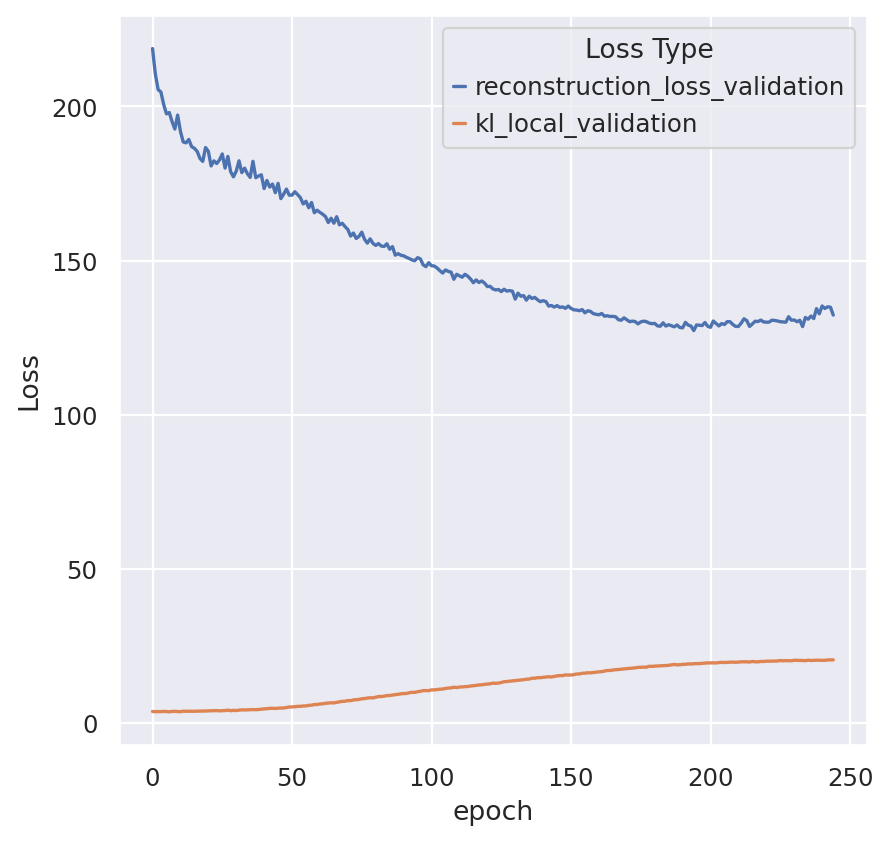

In [273]:
EPOCHS = 10000
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=50, batch_size=2000,
                    max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=0))
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=1, dropout_rate=0.1, prior_mixture=True)
model_cls.setup_anndata(joint_adata, batch_key='sample',)
joint_model = model_cls(joint_adata, **model_kwargs)
joint_model.train(**train_kwargs)
ax = plot_validation_loss(joint_model, semilogy=False)

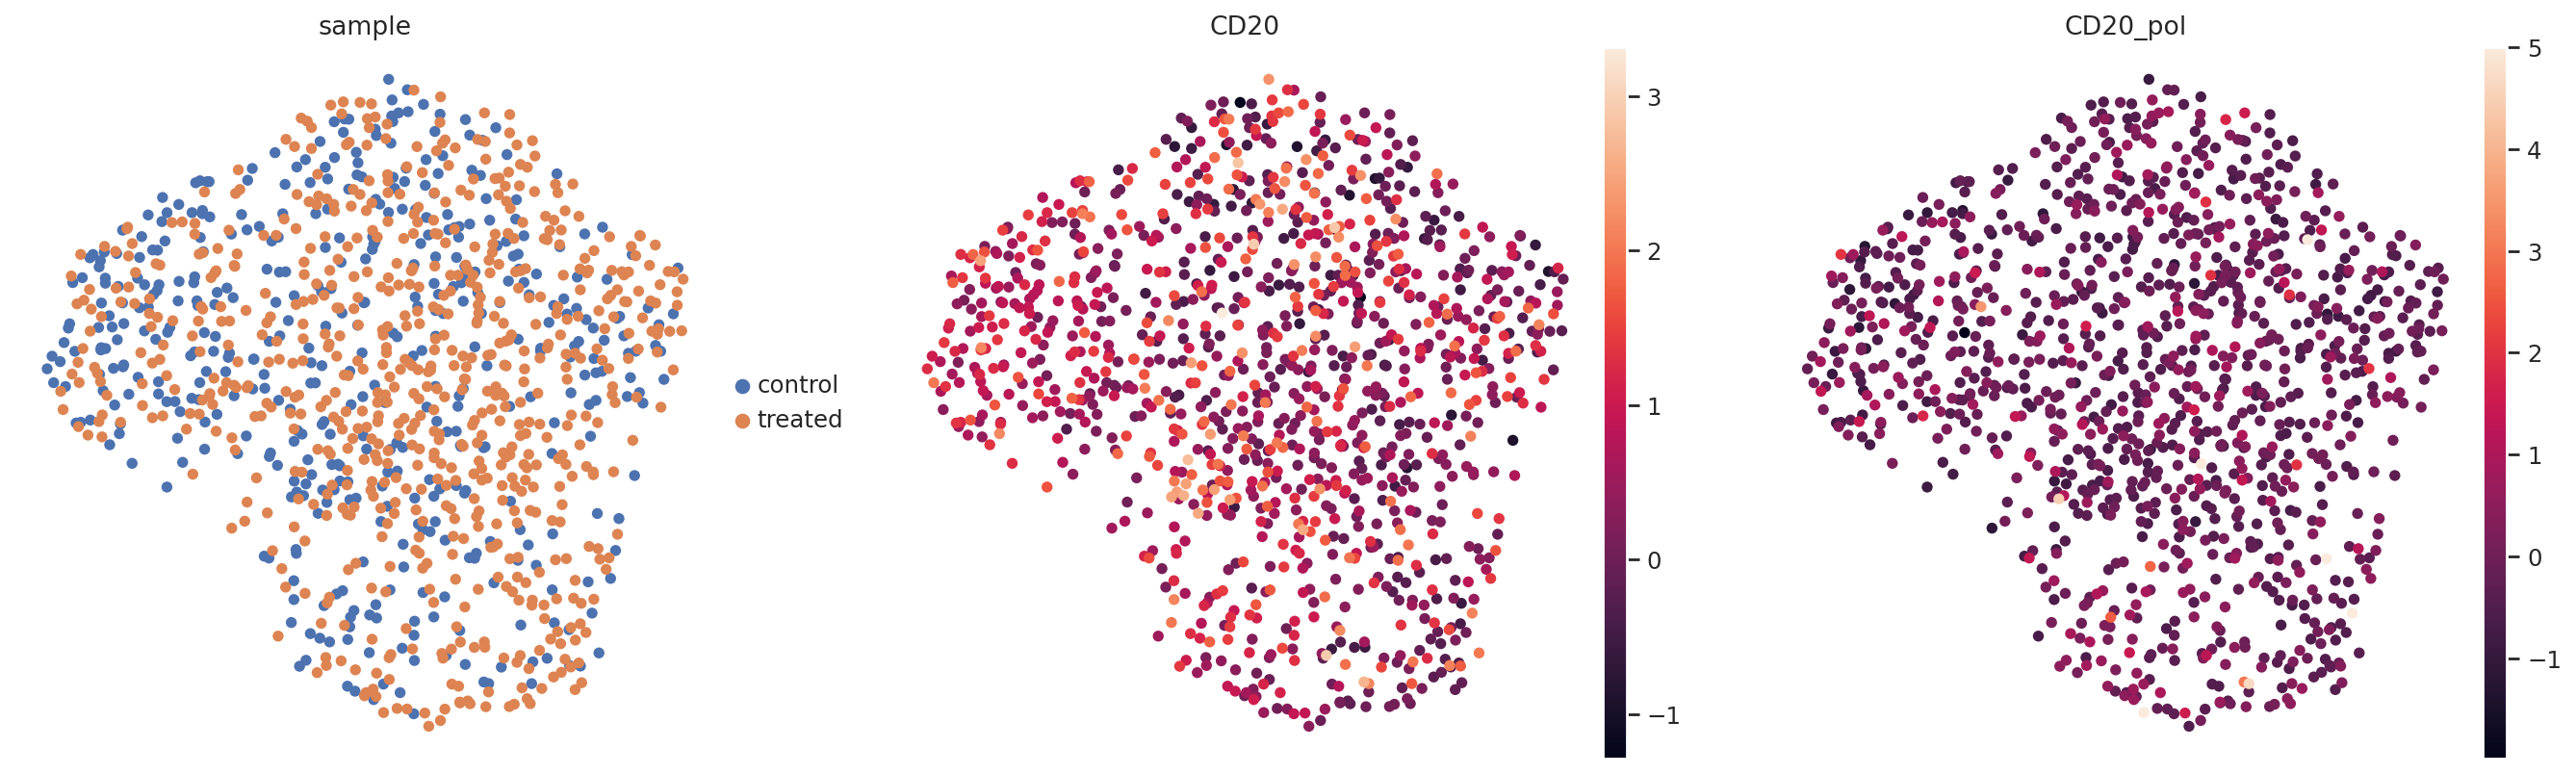

In [276]:
joint_adata.obsm['model_latent'] = joint_model.get_latent_representation()
sc.pp.neighbors(joint_adata, use_rep='model_latent', key_added='model_latent')
sc.tl.umap(joint_adata, neighbors_key='model_latent')
sc.pl.umap(joint_adata, color=['sample', 'CD20', 'CD20_pol'], vmax=[None, None, 5])

In [137]:
joint_de = joint_model.differential_expression(groupby='sample')
joint_de.sort_values(by='proba_not_de')

/tmp/ipykernel_2009889/1396647395.py:1: UserWarning: Protein expression exceeds clipping range, which can lead to poor DE results. Please adjust clipping range to data range.
  joint_de = joint_model.differential_expression(groupby='sample')


DE...:   0%|          | 0/2 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,is_de_fdr_0.05,comparison,group1,group2
CD37_pol,0.9660,0.0340,3.346803,0.047805,0.010583,0.0,0.25,4.702180,2.535788,5.803097,-16.646248,16.817127,True,imm_rantes vs Rest,imm_rantes,Rest
CD37_pol,0.9598,0.0402,3.172858,0.009909,0.046926,0.0,0.25,-4.876430,-2.523261,5.794807,-16.775187,17.004429,True,sol_rantes vs Rest,sol_rantes,Rest
CD50_pol,0.9598,0.0402,3.172858,0.011955,0.061604,0.0,0.25,-5.954415,-3.610995,6.397195,-17.360035,16.490351,True,sol_rantes vs Rest,sol_rantes,Rest
CD50_pol,0.9546,0.0454,3.045780,0.063819,0.012425,0.0,0.25,5.919132,3.653688,6.191442,-16.654804,17.383856,True,imm_rantes vs Rest,imm_rantes,Rest
CD44_pol,0.9438,0.0562,2.820997,0.052304,0.013866,0.0,0.25,4.521864,2.383278,6.673743,-16.792437,17.578165,True,imm_rantes vs Rest,imm_rantes,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD244_pol,0.4110,0.5890,-0.359833,-0.004325,-0.003466,0.0,0.25,-0.928986,0.000000,7.363546,-15.195055,15.267601,False,sol_rantes vs Rest,sol_rantes,Rest
CD11b,0.2664,0.7336,-1.012965,1.110749,1.174477,0.0,0.25,0.048749,0.000000,0.295292,-1.248465,1.858503,False,sol_rantes vs Rest,sol_rantes,Rest
CD11b,0.2630,0.7370,-1.030434,1.185561,1.108675,0.0,0.25,-0.042900,0.000000,0.287641,-1.970356,1.467408,False,imm_rantes vs Rest,imm_rantes,Rest
CD26,0.0040,0.9960,-5.517450,2.817309,2.601563,0.0,0.25,0.001548,0.000000,0.025756,-0.263065,0.604493,False,imm_rantes vs Rest,imm_rantes,Rest


In [ ]:
components_to_keep = pg_data_combined_pxl_object.adata[
    (pg_data_combined_pxl_object.adata.obs["molecules"] >= 10000)
    & (pg_data_combined_pxl_object.adata.obs["tau_type"] == "normal")
].obs.index

pg_data_combined_pxl_object.filter(components=components_to_keep).save(DATA_DIR/ "combined_data_filtered.pxl", force_overwrite=True)